In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Dataset Info
print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Features: {wine.feature_names}")

Dataset shape: (178, 13)
Class distribution: [59 71 48]
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [6]:
# Train a single decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [7]:
# Evaluate
y_pred_tree = tree.predict(X_test)
print("\nSingle Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))


Single Decision Tree Performance:
Accuracy: 0.9630

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



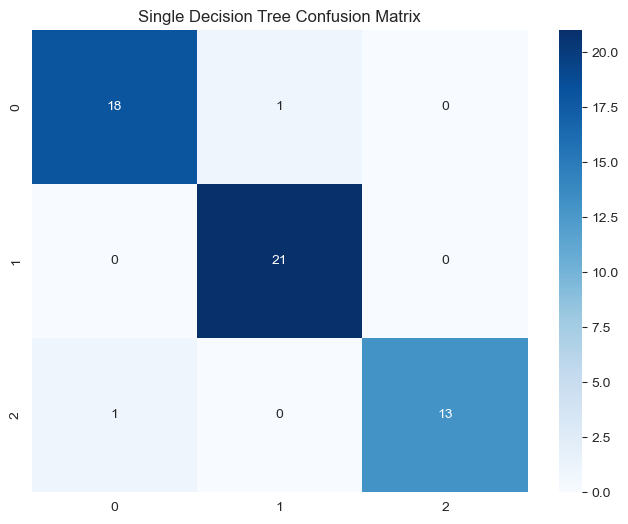

In [8]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='Blues')
plt.title("Single Decision Tree Confusion Matrix")
plt.show()

In [9]:
# Create bagging classifier with decision trees
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,  # Number of base estimators
    max_samples=0.8,   # Percentage of samples to draw from X to train each base estimator
    max_features=0.8,  # Percentage of features to draw from X to train each base estimator
    random_state=42,
    n_jobs=-1         # Use all available cores
)

In [10]:
# Train the bagging classifier
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.8,
                  max_samples=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42)

In [11]:
# Evaluate
y_pred_bag = bagging.predict(X_test)
print("\nBagging Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bag))


Bagging Classifier Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        14

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



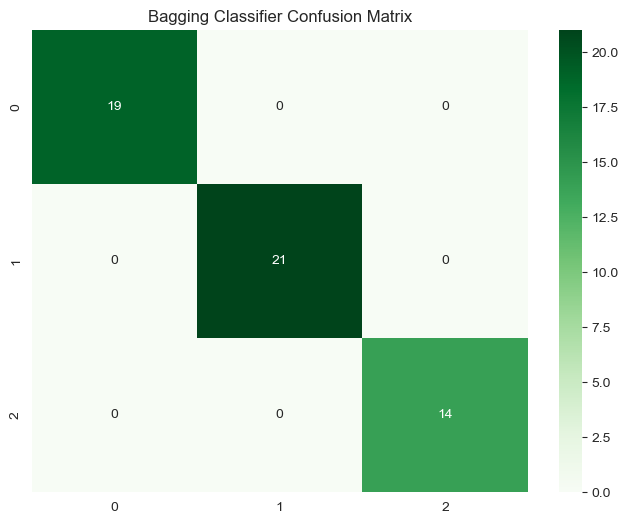

In [12]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Greens')
plt.title("Bagging Classifier Confusion Matrix")
plt.show()

In [16]:
# Get feature importances (fixed version)
def get_bagging_feature_importances(bagging_model, feature_names):
    """Calculate average feature importances from all base estimators"""
    importances = []
    for estimator in bagging_model.estimators_:
        if hasattr(estimator, 'feature_importances_'):
            importances.append(estimator.feature_importances_)
    return np.mean(importances, axis=0)

tree_importance = tree.feature_importances_
bagging_importance = get_bagging_feature_importances(bagging, wine.feature_names)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10,) and arg 3 with shape (13,).

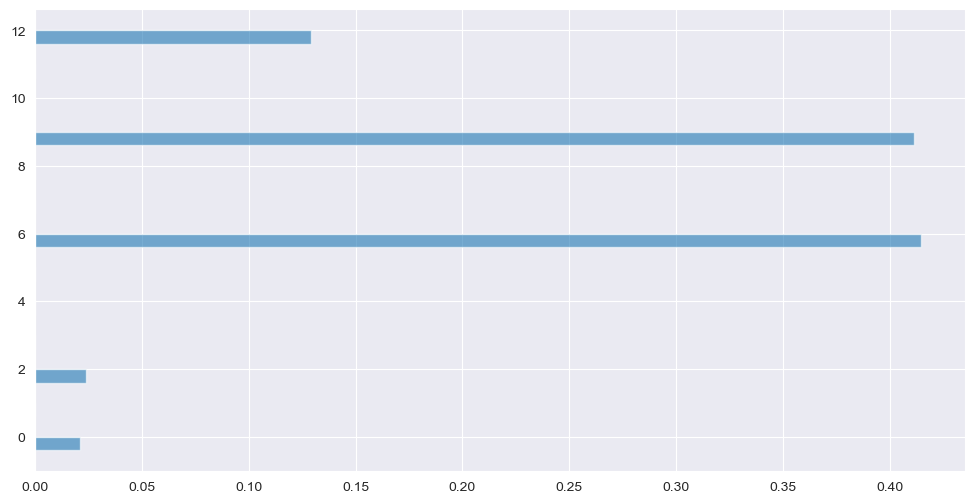

In [19]:
# Plot comparison
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(wine.feature_names)) - 0.2, tree_importance,
        height=0.4, alpha=0.6, label='Single Tree')
plt.barh(np.arange(len(wine.feature_names)) + 0.2, bagging_importance,
        height=0.4, alpha=0.6, label='Bagging (Average)')
plt.yticks(np.arange(len(wine.feature_names)), wine.feature_names)
plt.xlabel("Feature Importance")
plt.title("Comparison of Feature Importances")
plt.legend()
plt.tight_layout()
plt.show()

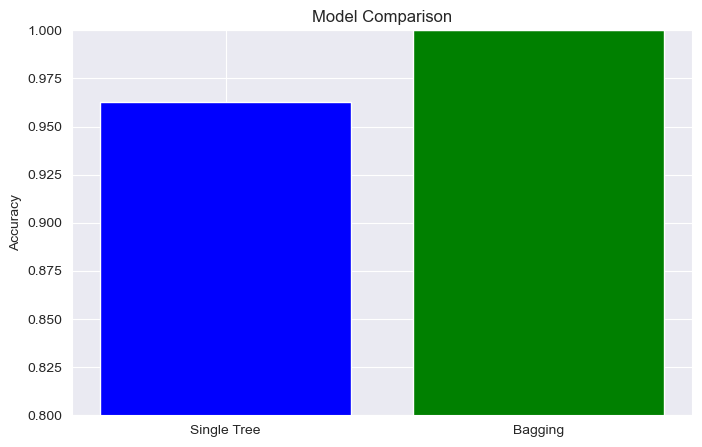

In [14]:
# Compare accuracy scores
plt.figure(figsize=(8, 5))
plt.bar(['Single Tree', 'Bagging'],
        [accuracy_score(y_test, y_pred_tree),
         accuracy_score(y_test, y_pred_bag)],
        color=['blue', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

In [21]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [22]:
# Train models on reduced data
tree_2d = DecisionTreeClassifier(random_state=42).fit(X_pca, y_train)
bagging_2d = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
).fit(X_pca, y_train)

In [23]:
# Create mesh grid for plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

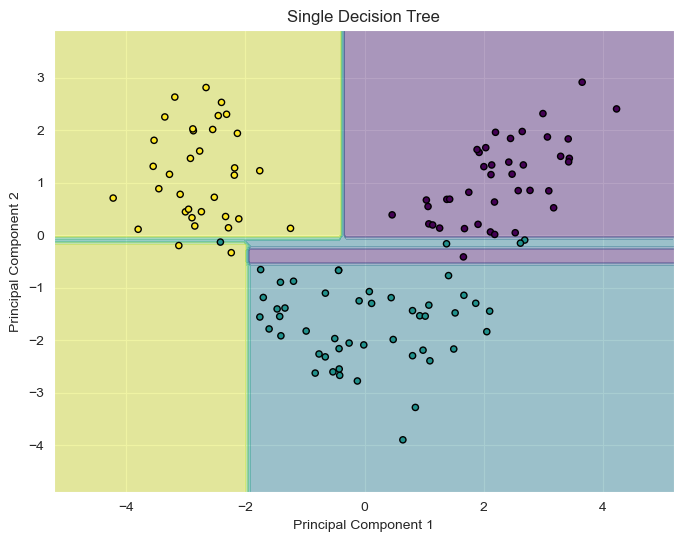

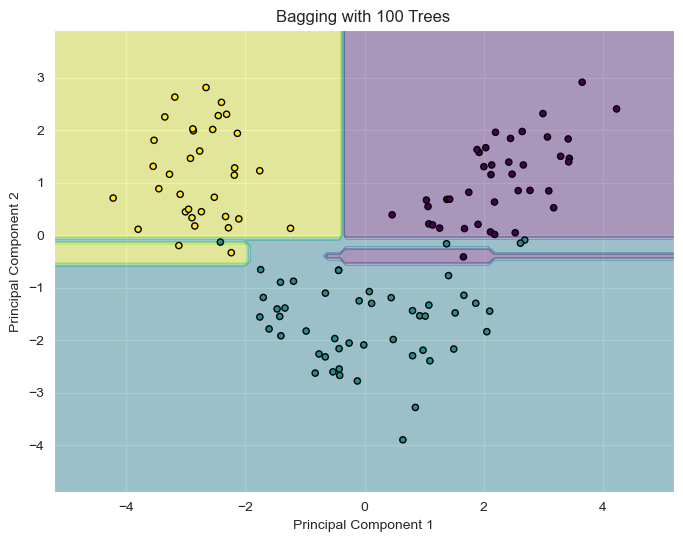

In [24]:
# Plot decision boundaries
titles = ['Single Decision Tree', 'Bagging with 100 Trees']
for i, clf in enumerate((tree_2d, bagging_2d)):
    plt.figure(figsize=(8, 6))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, s=20, edgecolor='k', cmap='viridis')
    plt.title(titles[i])
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()